In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
round(0.0313000001, 3)

0.031

In [66]:
from Task.TaskModel import TaskModel
from Task.CustomTasks import ABS, ACC
from Task import *

In [4]:
abss = ABS('abs', 0.03, 0.03, 0.02, 3.5)
acc = ACC('acc', 0.01, 0.01, 0.004, 6.5)
queue = [abss,acc]
queue

[abs, acc]

In [67]:
class WorstControl(TaskModel.TaskModel):
    def density(self):
        return self.wcet
    
    def run(self):
        self.output = 1
        
    def cost(self, x, u):
        

In [70]:
at = ITAsk('at', 0.01, 0.01, 0.004, 6.5)
at.period

0.01

In [5]:
from OS.RTOS import RTOS
from Processor.Processor import Processor
from Reliability.TAAF import TAAF

ImportError: No module named 'Reliability.TAAF'

In [ ]:
rtos = RTOS()
fail_rate = 3.1706e-09
reliability_model = TAAF(fail_rate)
processor = Processor(rtos, reliability_model)


In [ ]:
for t in queue:
    rtos.create_task(t)

In [ ]:
# clock = 0
# h = 0.001
# while clock < 0.1:
# #     print(rtos.ready_queue)
#     rtos.update(h, clock)
#     if rtos.running_task is not None:
#         print(rtos.running_task.name, clock, rtos.task_outputs)
#     clock += h

In [ ]:
# rtos = RTOS()
# fail_rate = 3.1706e-09
# reliability_model = TAAF(fail_rate)
# processor = Processor(rtos, reliability_model)
# for t in queue:
#     rtos.create_task(t)

In [ ]:
# clock = 0
# h = 0.001
# while clock < 0.1:
# #     print(rtos.ready_queue)
#     processor.update(h, clock)
#     print(processor.control_inputs, clock)
#     clock += h

In [ ]:
from __future__ import print_function, division
from sympy import init_printing
init_printing(use_latex='mathjax')

In [ ]:
# from sympy.abc import c, d, e, f, g, h
# from sympy.physics.vector import ReferenceFrame
# import scipy.integrate as integrate
# import math
# from sympy import Symbol
# from sympy import exp, integrate

In [ ]:
# r = 3.17e-9
# year = 3.154e+7
# t = Symbol('t')
# taaf = 1.1
# res = integrate(exp(-taaf * r * t), (t, 0, np.inf))
# res /= year
# res

In [ ]:
# 1 / (taaf * fail_rate) / year

In [ ]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn
import book_plots as bp

In [ ]:

dt = 0.1
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 1]])
kf.B = np.array([[dt], [ 1]])
kf.H = np.array([[1., 0]])

zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = 1.
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

plt.plot(xs, label='Kalman Filter')
bp.plot_measurements(zs)
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance');

In [ ]:
def sense(x, noise_scale):
    return np.array([[x[2][0] + randn()*noise_scale[0]],
                     [x[3][0] + randn()*noise_scale[1]]])
                     

class InvPen(object):
    def __init__(self, x0, A, B, K, h = 0.01, noise_scale=1):
        self.A = A
        self.B = B
        self.K = K
        self.x = x0
        self.noise_scale = noise_scale
        self.h = h
        

    def update(self):
        self.u = -np.dot(self.K, self.x) + randn() * self.noise_scale
#         print(self.u)
        self.u = np.reshape(self.u, (-1, 1))
#         print(self.A.shape, self.x.shape, self.B.shape,  self.u.shape)
        x_dot = np.dot(self.A, self.x) + np.dot(self.B, self.u)
#         print(x_dot)
        self.x += h * x_dot
#         print(self.x[2])
        

In [ ]:
# A = np.array([[0., 1.0, 0., 0.],
#                [0., -0.18182, 2.6727, 0.],
#                [0., 0., 0., 1.],
#                [0., -0.45455, 31.1820, 0.]])

# B = np.array([[0.0],
#                [1.8182],
#                [0.],
#                [4.5455]])

# K = np.array([-61.9930, -33.5054, 95.0600, 18.8300])
# C = np.array([[0., 0., 1., 0.]])
# x0 = np.array([[0.0],
#                [0.0],
#                [0.4],
#                [0.5]])

# pen = InvPen(x0, A, B, K)

# xs, zs = [], []
# for i in range(1000):
#     pen.update()
#     z = sense(pen.x)
#     xs.append(pen.x[2][0])
# #     print(xs)
#     zs.append(z)

# xs = np.asarray(xs)
# # xs
# # plt.plot(xs)

# plt.plot(xs, label='Kalman Filter')
# bp.plot_measurements(zs)
# plt.xlabel('time')
# plt.legend(loc=4)
# plt.ylabel('distance');



In [ ]:
from scipy import linalg
def kal_predict(A, B, x, P, u, h):
    x_new = x + h * (np.dot(A, x) + np.dot(B, u))
    P_new = np.dot(np.dot(A, P), A.T)
    return x_new, P_new

def kal_update(A, C, x, P, R, Z):
    threshold = 100
    error = Z - np.dot(C, x)
    if np.any(error > threshold):
        x_new = x
        P_new = P
    else:
        S = np.dot(np.dot(C, P), C.T) + R
#         print(S.shape, P.shape, C.shape)
        K = np.dot(np.dot(P, C.T), linalg.inv(S))
        x_new = x + np.dot(K, error)
        P_new = np.dot((np.eye(A.shape[0]) - np.dot(K, C)), P)
    return x_new, P_new

def MakeKF(A, B, C, P, K, h, dim_x = 4, dim_z = 2):

    kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    kf.x = np.zeros(dim_x)
    kf.P = P
#     kf.R = R
#     kf.Q = Q_discrete_white_noise(dim_x, h, 0)
#     print(A.shape, B.shape, K.shape)
    kf.F = 1 + h * (A - np.dot(B, K))
    kf.H = C
    return kf

In [ ]:
# KalmanFilter.update?

In [ ]:
from Task.CustomTasks import KalmanPredict
import Task.CustomTasks as ct

In [ ]:
a = np.array([(t * 0.001 * 1000, (t * 0.001 * 1000) % (0.001 * 1000), (t * 0.001 * 1000) % (0.001 * 1000) == 0 )for t in range(4000)])
a[10 : 20]

In [ ]:
use_pen = pd.read_csv('use_pen.csv')
use_kalman = pd.read_csv('use_kalman.csv')

# plt.figure()
# plt.hold(True)
# plt.grid(True)
# plt.plot(use_pen, c='r', linewidth = 3)
# plt.plot(use_kalman, c='b', linewidth = 1)
combine = pd.concat([use_pen, use_kalman], axis=1)
combine.columns = ['pen', 'kalman']
combine['diff'] = abs(combine['pen'] - combine['kalman'])
combine.head(10)

In [ ]:
time = np.arange(0, 10, h)
time = np.reshape(time, (len(time), 1))
clock = [i for i in np.arange(0, 10, h)]
clock[0:10], time[0:10]

In [ ]:
h = 0.001
kf_period = 0.02
kf_deadline = kf_period
kf_wcet = 0.01
A = np.array([[0., 1.0, 0., 0.],
               [0., -0.18182, 2.6727, 0.],
               [0., 0., 0., 1.],
               [0., -0.45455, 31.1820, 0.]])

B = np.array([[0.0],
               [1.8182],
               [0.],
               [4.5455]])

K = np.array([[-61.9930, -33.5054, 95.0600, 18.8300]])
C = np.array([[0., 0., 1., 0.],
              [0., 0., 0., 1.]])
x0 = np.array([[0.0],
               [0.0],
               [0.4],
               [0.5]])

P = np.array([[0., 0., 0., 0.],
              [0., 0., 0., 0.],
              [0., 0., 1000., 0.],
              [0., 0., 0., 1000.]])

F = 1 + kf_period * (A - np.dot(B, K))

angle_noise = 0.05
rate_noise = 0.005
angle_noise2 = 0.005
rate_noise2 = 0.5
actuator_noise = 2
R = np.array([[angle_noise, 0.],
              [0., rate_noise]])
R2 = np.array([[angle_noise2, 0.],
              [0., rate_noise2]])

pen = InvPen(x0, A, B, K, h, actuator_noise)

zs = sense(x0, [angle_noise, rate_noise])
xs = x0
xtract = np.array([[0.0],
                   [0.0],
                   [0.0],
                   [0.5]])

kf = MakeKF(A, B, C, P, K, h)

kf2 = MakeKF(A, B, C, P, K, h)

kf3 = ct.makeLinearKF(A, B, C, P, F)

Rs = {'sensor1' : R, 'sensor2' : R2}

localizer = KalmanPredict('kalman predict', kf_period, kf_deadline, kf_wcet, 4, kf3, Rs)

for t in range(4000):
    pen.update()
    z = sense(pen.x, [angle_noise, rate_noise])
    z2 = sense(pen.x, [angle_noise2, rate_noise2])
    all_z = {'sensor1' : z[:, -1], 'sensor2' : z2[:, -1]}
    xs = np.append(xs, pen.x, axis=1)
    if (t ) % (kf_period * 1. / h) < 0.001:
        localizer.run(all_z)
    x_predict = np.reshape(localizer.output, (-1, 1))
    xtract = np.append(xtract, x_predict, axis=1)

# xs = np.asarray(xs)
# xs
# plt.plot(xs)
plt.figure()
plt.hold(True)
plt.grid(True)
plt.plot(xtract[2, :], c = 'b', label='Kalman Filter', linewidth=2)
plt.plot(xs[2, :], c= 'r', label='True value', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Angle (rad)')
# bp.plot_measurements(zs)
# plt.xlabel('time')
plt.legend(loc=4)
# plt.ylabel('distance');


plt.figure()
plt.hold(True)
plt.grid(True)
plt.plot(xtract[3, :], c = 'b', label='Kalman Filter', linewidth=2)
plt.plot(xs[3, :], c= 'r', label='True value', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Angular Rate (rad/s)')
# bp.plot_measurements(zs)
# plt.xlabel('time')
plt.legend(loc=4)
# plt.ylabel('distance');
xtract.shape

In [ ]:
h = 0.001
kf_period = 0.02
kf_deadline = kf_period
kf_wcet = 0.01
A = np.array([[0., 1.0, 0., 0.],
               [0., -0.18182, 2.6727, 0.],
               [0., 0., 0., 1.],
               [0., -0.45455, 31.1820, 0.]])

B = np.array([[0.0],
               [1.8182],
               [0.],
               [4.5455]])

K = np.array([[-61.9930, -33.5054, 95.0600, 18.8300]])
C = np.array([[0., 0., 1., 0.],
              [0., 0., 0., 1.]])
x0 = np.array([[0.0],
               [0.0],
               [0.4],
               [0.5]])

P = np.array([[0., 0., 0., 0.],
              [0., 0., 0., 0.],
              [0., 0., 1000., 0.],
              [0., 0., 0., 1000.]])

F = 1 + kf_period * (A - np.dot(B, K))

angle_noise = 0.05
rate_noise = 0.005
angle_noise2 = 0.005
rate_noise2 = 0.5
actuator_noise = 2
R = np.array([[angle_noise, 0.],
              [0., rate_noise]])
R2 = np.array([[angle_noise2, 0.],
              [0., rate_noise2]])

pen = InvPen(x0, A, B, K, h, actuator_noise)

zs = sense(x0, [angle_noise, rate_noise])
xs = x0
xtract = np.array([[0.0],
                   [0.0],
                   [0.0],
                   [0.5]])

kf = MakeKF(A, B, C, P, K, h)

kf2 = MakeKF(A, B, C, P, K, h)

kf3 = ct.makeLinearKF(A, B, C, P, F)

Rs = {'sensor1' : R, 'sensor2' : R2}

localizer = KalmanPredict('kalman', kf_period, kf_deadline, kf_wcet, 4, kf3, Rs)
acc = ACC('acc', 0.01, 0.01, 0.004, 6.5)
queue = [localizer, acc]
rtos = RTOS()
for task in queue:
    rtos.create_task(task)

for t in range(4000):
    pen.update()
    z = sense(pen.x, [angle_noise, rate_noise])
    z2 = sense(pen.x, [angle_noise2, rate_noise2])
    all_z = {'sensor1' : z[:, -1], 'sensor2' : z2[:, -1]}
    xs = np.append(xs, pen.x, axis=1)
    rtos.task_inputs[acc.name] = 0
    rtos.task_inputs[localizer.name] = all_z
    rtos.update(h, t)
#     if (t ) % (kf_period * 1. / h) < 0.001:
#         localizer.run(all_z)
    x_predict = np.reshape(rtos.task_outputs[localizer.name], (-1, 1))
    print(x_predict)
    xtract = np.append(xtract, x_predict, axis=1)

# xs = np.asarray(xs)
# xs
# plt.plot(xs)
plt.figure()
plt.hold(True)
plt.grid(True)
plt.plot(xtract[2, :], c = 'b', label='Kalman Filter', linewidth=2)
plt.plot(xs[2, :], c= 'r', label='True value', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Angle (rad)')
# bp.plot_measurements(zs)
# plt.xlabel('time')
plt.legend(loc=4)
# plt.ylabel('distance');


plt.figure()
plt.hold(True)
plt.grid(True)
plt.plot(xtract[3, :], c = 'b', label='Kalman Filter', linewidth=2)
plt.plot(xs[3, :], c= 'r', label='True value', linewidth = 1)
plt.xlabel('Time (ms)')
plt.ylabel('Angular Rate (rad/s)')
# bp.plot_measurements(zs)
# plt.xlabel('time')
plt.legend(loc=4)
# plt.ylabel('distance');
xtract.shape

In [ ]:
rtos = RTOS()
fail_rate = 3.1706e-09
reliability_model = TAAF(fail_rate)
processor = Processor(rtos, reliability_model)
queue2 = [abss, acc]
for t in queue2:
    rtos.create_task(t)

In [ ]:
clock = 0
h = 0.001
end = 50
taaf = np.zeros([end / h, 1])
time = np.arange(0, end, h)
time = np.reshape(time, (len(time), 1))
taaf[0] = 1
mttf = np.zeros([end / h, 1])
mttf[0] = 10
i = 1
for i in np.arange(1, len(time)):
#     print(rtos.ready_queue)
    processor.update(h, clock)
#     print(processor.control_inputs, clock)
    taaf[i] = processor.reliability_model.taaf
    mttf[i] = processor.reliability_model.mttf_in_years
    clock += h

In [ ]:
plt.plot(taaf)

In [ ]:
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(taaf)
ax1.set_title('taaf')
ax2.plot(mttf)
ax2.set_title('mttf in years')


In [ ]:
clock = 0
h = 0.001
end = 10
taaf = np.zeros([end / h, 1])
mttf = np.zeros([end / h, 1])
T = np.zeros([end / h, 1])
time = np.arange(0, end, h)
time = np.reshape(time, (len(time), 1))
taaf[0] = 1
i = 1
des_fail_rate = 3.1706e-09
reliability_model = TAAF(des_fail_rate)
u = 0.5
power = 5
Tss = reliability_model.steady_state_temperature(power)
Tss_idle = reliability_model.steady_state_temperature(1)
for i in np.arange(1, len(time)):
    if time[i] <= time[-1] * u:
        reliability_model.update_temperature(Tss, h)
    else:
        reliability_model.update_temperature(Tss_idle, h)
    reliability_model.update_reliability()
    taaf[i] = reliability_model.taaf
    mttf[i] = reliability_model.mttf_in_years
    T[i] = reliability_model.abs_temperature - 273.15
    clock += h

In [ ]:
# mttf[0:50]

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(taaf)
ax1.grid(True)
ax1.set_title('taaf')
ax2.plot(mttf)
ax2.grid(True)
ax2.set_title('mttf in years')

In [2]:
sss = np.genfromtxt ('sss.csv', delimiter=",")
c_sss = np.genfromtxt ('c_sss.csv', delimiter=",")

In [3]:
sss = sss.T
c_sss = c_sss.T

In [4]:
c_sss = np.append(c_sss, np.zeros((len(c_sss), 1)), axis=1)
sss = np.append(sss, np.ones((len(sss), 1)), axis=1)


In [5]:
data = np.append(sss, c_sss, axis=0)
data.shape

(8626, 5)

In [6]:
data = pd.DataFrame(data, columns=['cart pos', 'cart vel', 'angle', 'rate', 'safe'])

In [7]:
X = data.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values
y = data.ix[:, 'safe'].values
X

array([[ 0. ,  0. ,  0. ,  0. ],
       [-1.5,  1. , -0.4, -3. ],
       [-1.5,  1. , -0.4, -2. ],
       ..., 
       [ 3.5,  3. ,  0.5,  1. ],
       [ 3.5,  3. ,  0.5,  2. ],
       [ 3.5,  3. ,  0.5,  3. ]])

In [10]:
from sklearn.cross_validation import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

In [17]:
knn = KNeighborsClassifier(3)
knn.fit(X_train_norm, y_train)
knn.score(X_train_norm, y_train), knn.score(X_test_norm, y_test)

(0.99149813216539995, 0.97914252607184238)

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 1000, random_state = 0, n_jobs = -1)
forest.fit(X_train_norm, y_train)
importances = forest.feature_importances_
cols = data.columns
importances = zip(cols, importances)
for name, val in importances:
    print(name, val)

forest.score(X_train_norm, y_train), forest.score(X_test_norm, y_test)

cart pos 0.398637660447
cart vel 0.22569655744
angle 0.148150313977
rate 0.227515468135


(0.99987118382068785, 0.98377752027809962)

In [8]:
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

In [20]:
X, y = data.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values, data.ix[:, ['safe']].values
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]
y

array([[1],
       [1],
       [1],
       ..., 
       [0],
       [0],
       [0]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

In [22]:
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

In [24]:
clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced', C = 1000., probability=True))
clf.fit(X_train_norm, y_train)
y_score = clf.fit(X_train_norm, y_train).decision_function(X_test_norm)
clf.score(X_test_norm, y_test)

0.98551564310544615

In [189]:
# Compute Precision-Recall and plot curve
n_classes = 2
prcsn = dict()
recall = dict()
average_precision = dict()
thrshld = {}
for i in range(1):
    prcsn[i], recall[i], thrshld[i] = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# min_prcsn1 = 1.0  # let's do it for s1
# min_thrshld1=min([thrshld[0][i] for i in range(len(thrshld[0])) if prcsn[0][i]>=min_prcsn1])

# min_prcsn2 = 1.0  # let's do it for s2
# min_thrshld2=min([thrshld[1][i] for i in range(len(thrshld[1])) if prcsn[1][i]>=min_prcsn2])

# y_pred_adjusted=[1 if y_s[0]>min_thrshld1 else 2 if y_s[1] > min_thrshld2 else 3 for y_s in y_score]
# y_pred_adjusted = label_binarize(y_pred_adjusted, classes=[1, 2, 3])
# # y_pred_adjusted
# # np.array_equal(y_pred_adjusted, y_test)
# print('accuracy of adjusted y pred: ', 
#       sum([np.array_equal(y_pred_adjusted[i], y_test[i]) for i in np.arange(len(y_pred_adjusted))]) / len(y_pred_adjusted))
# # len(y_pred_adjusted), len(y_test), 

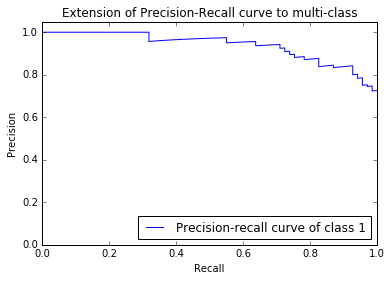

In [190]:
# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall[i], prcsn[i],label='Precision-recall curve of class 1')
# for i in range(n_classes):
#     plt.plot(recall[i], prcsn[i],
#              label='Precision-recall curve of class {0} (area = {1:0.2f})'
#                    ''.format(i+1, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [6]:
cd Data/InvPendulum/

/home/ares/Dropbox/Phd/AdaFT/Data/InvPendulum


In [7]:
import seaborn as sns
import matplotlib 
from sklearn.ensemble import RandomForestRegressor

In [8]:
data = np.genfromtxt ('subspace_final.csv', delimiter=",")
data2 = np.genfromtxt('sss_final.csv', delimiter=',')
data = pd.DataFrame(data, columns=['cart pos', 'cart vel', 'angle', 'rate', 'level'])
data2 = pd.DataFrame(data2, columns=['cart pos', 'cart vel', 'angle', 'rate', 'level'])
data2 = data2[data2['level'] == 3]
data3 = pd.concat((data, data2), axis=0)
data3.head()

,cart pos,cart vel,angle,rate,level
0,-1.0,-1.0,-0.20,-5.0,1.0
1,-1.0,-1.0,-0.20,-4.0,1.0
2,-1.0,-1.0,-0.15,-5.0,1.0
3,-1.0,-1.0,-0.15,-4.0,1.0
4,-1.0,-1.0,-0.10,-5.0,1.0


In [3]:
from pandas.tools.plotting import scatter_matrix

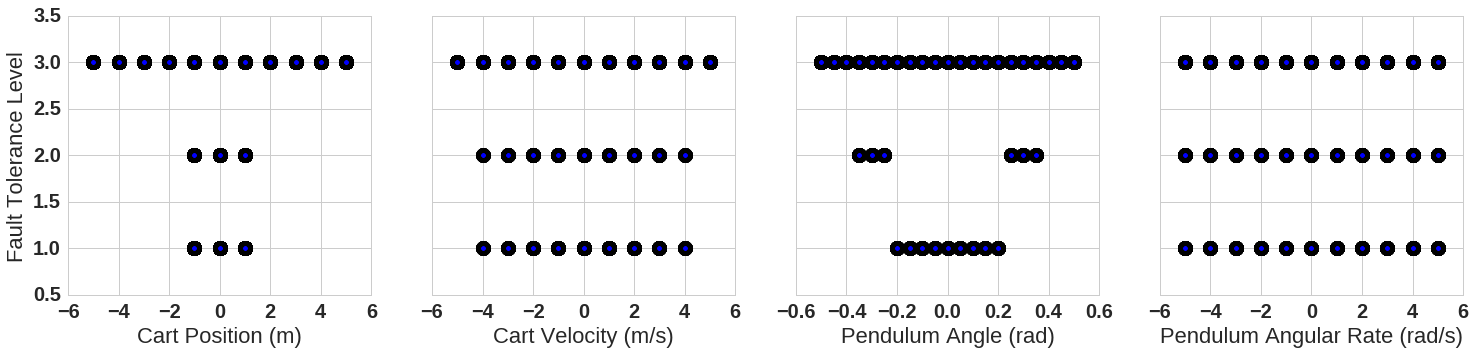

In [144]:

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(25,5))
ax1.scatter(data3['cart pos'], data3['level'], linewidths=10)
ax1.set_xlabel('Cart Position (m)')
ax2.scatter(data3['cart vel'], data3['level'], linewidths=10)
ax2.set_xlabel('Cart Velocity (m/s)')
ax3.scatter(data3['angle'], data3['level'], linewidths=10)
ax3.set_xlabel('Pendulum Angle (rad)')
ax4.scatter(data3['rate'], data3['level'], linewidths=10)
ax4.set_xlabel('Pendulum Angular Rate (rad/s)')
ax1.set_ylabel('Fault Tolerance Level')

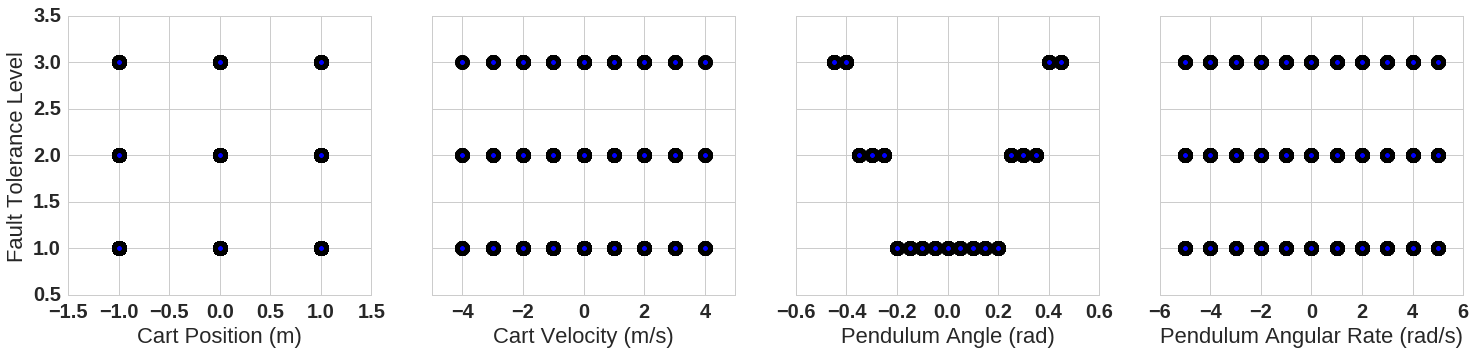

In [142]:
# sns.set(style='whitegrid', context='notebook', font_scale=2)
# # sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# columns=['cart pos', 'cart vel', 'angle', 'rate', 'level']
# sns.pairplot(data[columns])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(25,5))
ax1.scatter(data['cart pos'], data['level'], linewidths=10)
ax1.set_xlabel('Cart Position (m)')
ax2.scatter(data['cart vel'], data['level'], linewidths=10)
ax2.set_xlabel('Cart Velocity (m/s)')
ax3.scatter(data['angle'], data['level'], linewidths=10)
ax3.set_xlabel('Pendulum Angle (rad)')
ax4.scatter(data['rate'], data['level'], linewidths=10)
ax4.set_xlabel('Pendulum Angular Rate (rad/s)')
ax1.set_ylabel('Fault Tolerance Level')

In [12]:
X = data3.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values
y = data3.ix[:, 'level'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

forest = RandomForestClassifier(n_estimators = 2, random_state = 0, n_jobs = -1)
forest.fit(X_train_norm, y_train)
importances = forest.feature_importances_
cols = data.columns
importances = zip(cols, importances)
for name, val in importances:
    print(name, val)

forest.score(X_train_norm, y_train), forest.score(X_test_norm, y_test)

('cart pos', 0.14553876231012777)
('cart vel', 0.32292206816003344)
('angle', 0.26352061287208683)
('rate', 0.26801855665775204)


(0.99558735837805601, 0.98569384835479257)

In [3]:
import sys

In [49]:

X = data.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values
y = data.ix[:, 'level'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

forest = RandomForestClassifier(n_estimators = 2, random_state = 0, n_jobs = -1)
forest.fit(X_train_norm, y_train)
importances = forest.feature_importances_
cols = data.columns
importances = zip(cols, importances)
for name, val in importances:
    print(name, val)

forest.score(X_train_norm, y_train), forest.score(X_test_norm, y_test)

cart pos 0.00173448031558
cart vel 0.0132626612362
angle 0.976775378409
rate 0.00822748003956


(0.98765432098765427, 0.96330275229357798)

In [50]:
pickle.dump(forest, open('invpen_forest.pkl', 'wb'))

In [2]:
from sklearn.tree import DecisionTreeClassifier


In [47]:

X = data3.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values
y = data3.ix[:, 'level'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

clf = DecisionTreeClassifier(max_depth=9, class_weight='balanced')
clf.fit(X_train_norm, y_train)
importances = clf.feature_importances_
cols = data.columns
importances = zip(cols, importances)
for name, val in importances:
    print(name, val)

clf.score(X_train_norm, y_train), clf.score(X_test_norm, y_test)

('cart pos', 0.37155003684695331)
('cart vel', 0.04067470216705335)
('angle', 0.56466176721770345)
('rate', 0.023113493768289847)


(0.90248459550785132, 0.9066523605150214)

In [62]:
%%time
clf.predict(X_test[0])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 528 µs


/home/ares/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 3.])

In [21]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 
from sklearn import tree


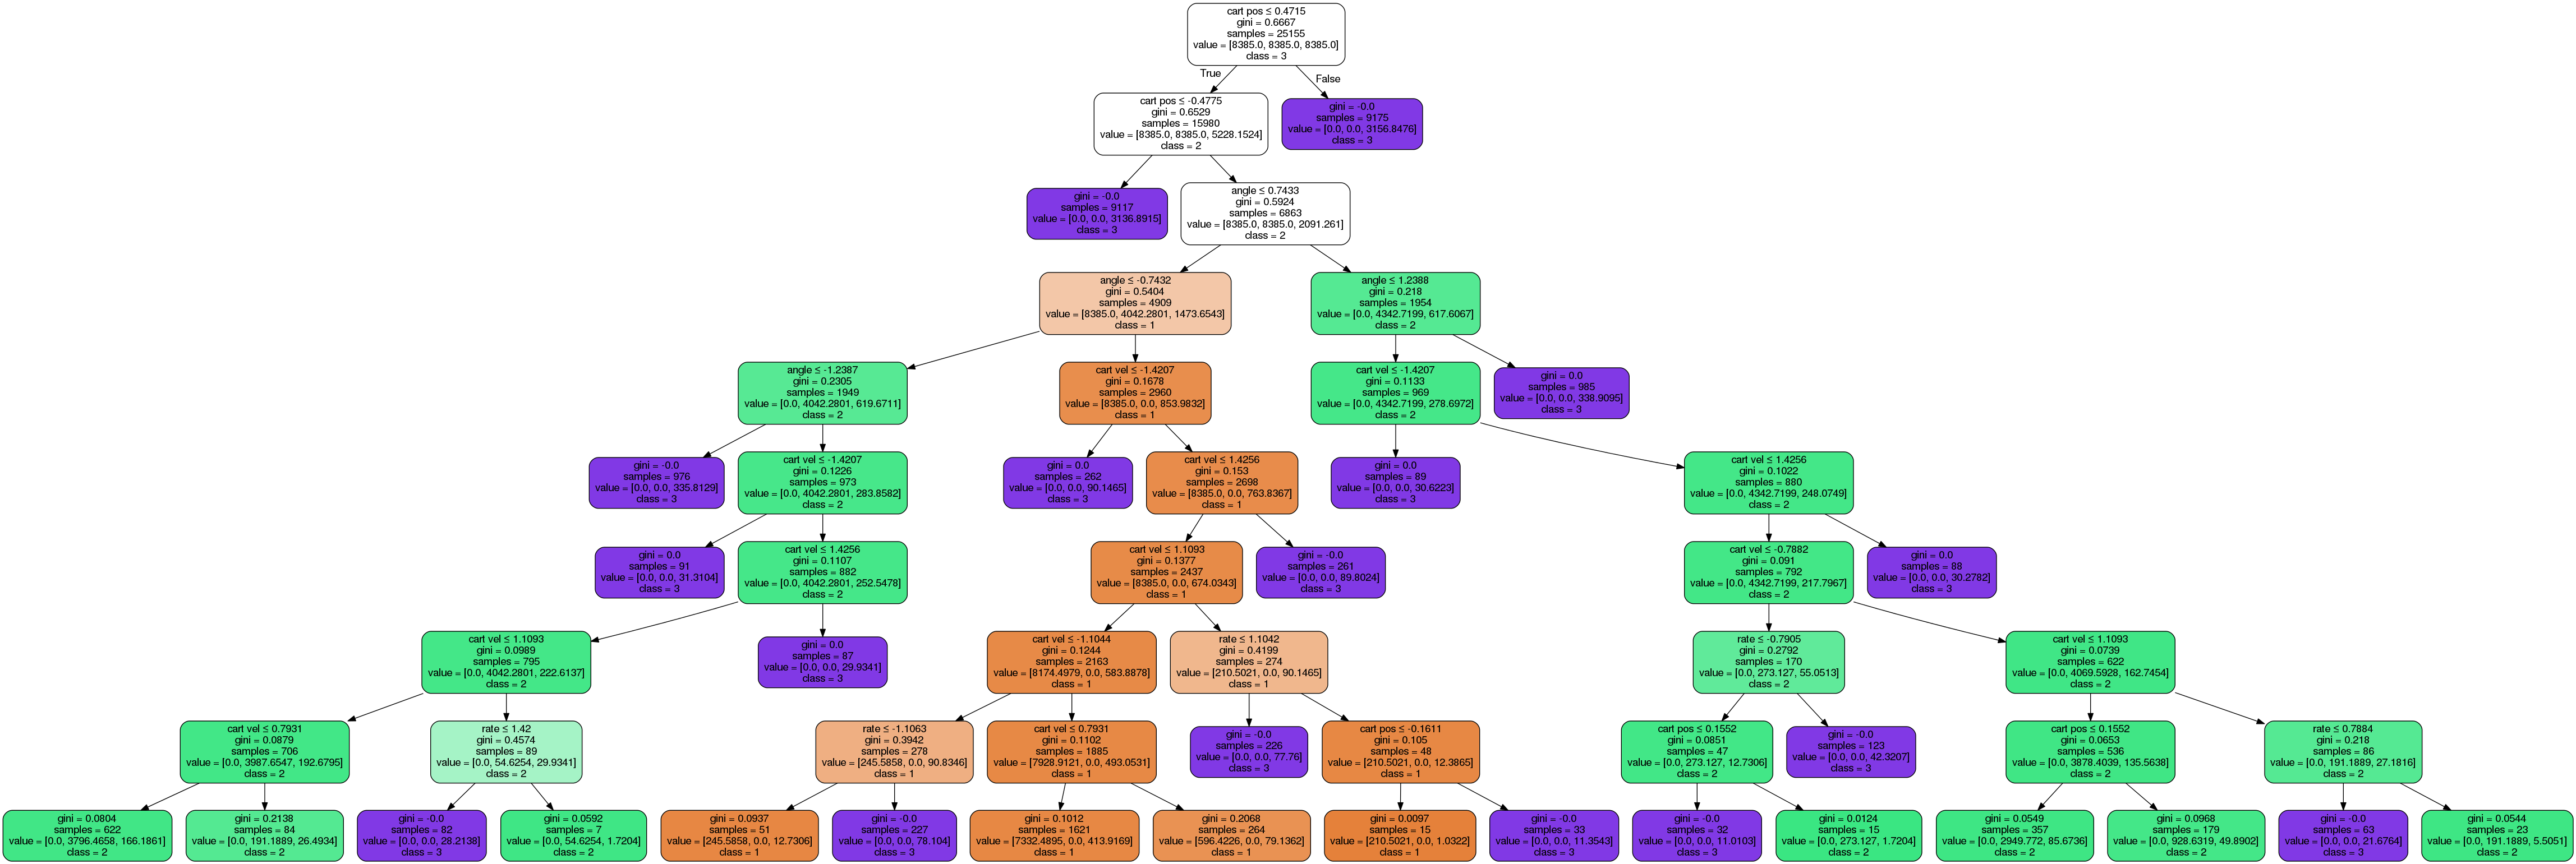

In [48]:

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=data.columns[0:-1],  
                         class_names=['1', '2', '3'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [29]:
import pickle

In [21]:
sys.getsizeof(tree)

56

In [58]:
pickle.dump(tree, open('invpen_tree.pkl', 'wb'))

accuracy of adjusted y pred:  0.9861751152073732


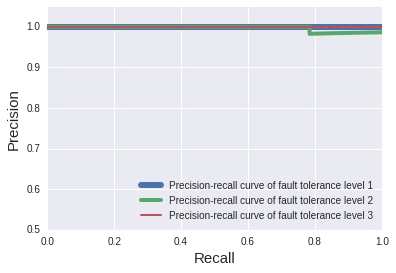

In [21]:
X, y = data.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values, data.ix[:, ['level']].values
y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)
clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced', C = 100., probability=True))
clf.fit(X_train_norm, y_train)
y_score = clf.fit(X_train_norm, y_train).decision_function(X_test_norm)
clf.score(X_test_norm, y_test)

# Compute Precision-Recall and plot curve
n_classes = 3
prcsn = dict()
recall = dict()
average_precision = dict()
thrshld = {}
for i in range(n_classes):
    prcsn[i], recall[i], thrshld[i] = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

min_prcsn1 = 0.98  # let's do it for s1
min_thrshld1=min([thrshld[0][i] for i in range(len(thrshld[0])) if prcsn[0][i]>=min_prcsn1])

min_prcsn2 = 0.98  # let's do it for s2
min_thrshld2=min([thrshld[1][i] for i in range(len(thrshld[1])) if prcsn[1][i]>=min_prcsn2])

y_pred_adjusted=[1 if y_s[0]>min_thrshld1 else 2 if y_s[1] > min_thrshld2 else 3 for y_s in y_score]
y_pred_adjusted = label_binarize(y_pred_adjusted, classes=[1, 2, 3])
# y_pred_adjusted
# np.array_equal(y_pred_adjusted, y_test)
print('accuracy of adjusted y pred: ', 
      sum([np.array_equal(y_pred_adjusted[i], y_test[i]) for i in np.arange(len(y_pred_adjusted))]) / len(y_pred_adjusted))
# len(y_pred_adjusted), len(y_test), 

# Plot Precision-Recall curve for each class
plt.clf()
for i in range(n_classes):
    plt.plot(recall[i], prcsn[i], linewidth = 6 - 2*i,
             label='Precision-recall curve of fault tolerance level {0}'
                   ''.format(i+1))

plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.05])
plt.xlabel('Recall', fontsize= 15)
plt.ylabel('Precision', fontsize= 15)

# plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

(30, 5)

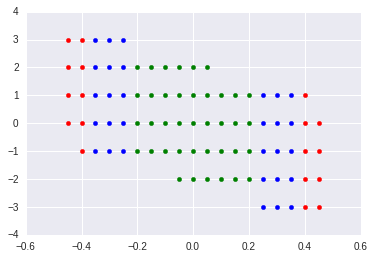

In [52]:
data_to_plot_1 = data.ix[(data['cart pos'] == 0) & (data['cart vel'] == 0) & (data['level'] == 1)]
data_to_plot_2 = data.ix[(data['cart pos'] == 0) & (data['cart vel'] == 0) & (data['level'] == 2)]
data_to_plot_3 = data.ix[(data['cart pos'] == 0) & (data['cart vel'] == 0) & (data['level'] == 3)]
plt.figure()
plt.hold()
plt.scatter(data_to_plot_1['angle'].values, data_to_plot_1['rate'].values, color = 'green')
plt.scatter(data_to_plot_2['angle'], data_to_plot_2['rate'], color = 'blue')
plt.scatter(data_to_plot_3['angle'], data_to_plot_3['rate'], color = 'red')
data_to_plot_2.shape

accuracy of adjusted y pred:  0.9899839027007691


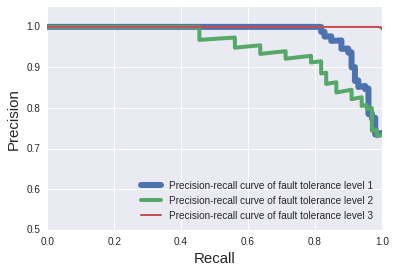

In [24]:
X, y = data3.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values, data3.ix[:, ['level']].values
y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)
clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced', C = 500., probability=True))
clf.fit(X_train_norm, y_train)
y_score = clf.fit(X_train_norm, y_train).decision_function(X_test_norm)
clf.score(X_test_norm, y_test)

# Compute Precision-Recall and plot curve
n_classes = 3
prcsn = dict()
recall = dict()
average_precision = dict()
thrshld = {}
for i in range(n_classes):
    prcsn[i], recall[i], thrshld[i] = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

min_prcsn1 = 0.99  # let's do it for s1
min_thrshld1=min([thrshld[0][i] for i in range(len(thrshld[0])) if prcsn[0][i]>=min_prcsn1])

min_prcsn2 = 0.99  # let's do it for s2
min_thrshld2=min([thrshld[1][i] for i in range(len(thrshld[1])) if prcsn[1][i]>=min_prcsn2])

y_pred_adjusted=[1 if y_s[0]>min_thrshld1 else 2 if y_s[1] > min_thrshld2 else 3 for y_s in y_score]
y_pred_adjusted = label_binarize(y_pred_adjusted, classes=[1, 2, 3])
# y_pred_adjusted
# np.array_equal(y_pred_adjusted, y_test)
print('accuracy of adjusted y pred: ', 
      sum([np.array_equal(y_pred_adjusted[i], y_test[i]) for i in np.arange(len(y_pred_adjusted))]) / len(y_pred_adjusted))
# len(y_pred_adjusted), len(y_test), 

# Plot Precision-Recall curve for each class
plt.clf()
for i in range(n_classes):
    plt.plot(recall[i], prcsn[i], linewidth = 6 - 2*i,
             label='Precision-recall curve of fault tolerance level {0}'
                   ''.format(i+1))

plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.05])
plt.xlabel('Recall', fontsize= 15)
plt.ylabel('Precision', fontsize= 15)

# plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [74]:
data1 = np.genfromtxt ('sss_final.csv', delimiter=",")
data1 = pd.DataFrame(data1, columns=['cart pos', 'cart vel', 'angle', 'rate', 'level'])
data1.shape

(27951, 5)

In [51]:
X = data1.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values
y = data1.ix[:, 'level'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)

forest = RandomForestClassifier(n_estimators = 1000, random_state = 0, n_jobs = -1)
forest.fit(X_train_norm, y_train)
importances = forest.feature_importances_
cols = data.columns
importances = zip(cols, importances)
for name, val in importances:
    print(name, val)

forest.score(X_train_norm, y_train), forest.score(X_test_norm, y_test)

cart pos 0.285668824656
cart vel 0.30059972532
angle 0.155070059578
rate 0.258661390446


(1.0, 0.99713876967095849)

/home/ares/anaconda3/lib/python3.5/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/home/ares/anaconda3/lib/python3.5/site-packages/sklearn/multiclass.py:70: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


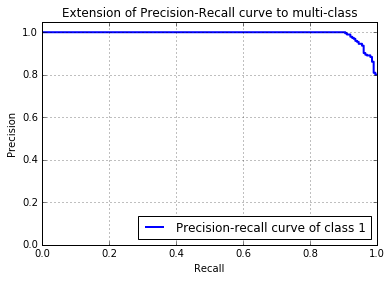

In [65]:
X, y = data1.ix[:, ['cart pos', 'cart vel', 'angle', 'rate']].values, data1.ix[:, ['level']].values
y = label_binarize(y, classes=[1, 2, 3])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)
stdsc = StandardScaler()
X_train_norm = stdsc.fit_transform(X_train)
X_test_norm = stdsc.transform(X_test)
clf = OneVsRestClassifier(SVC(kernel='rbf', class_weight='balanced', C = 500., probability=True))
clf.fit(X_train_norm, y_train)
y_score = clf.fit(X_train_norm, y_train).decision_function(X_test_norm)
clf.score(X_test_norm, y_test)

# Compute Precision-Recall and plot curve
n_classes = 2
prcsn = dict()
recall = dict()
average_precision = dict()
thrshld = {}
for i in range(n_classes):
    prcsn[i], recall[i], thrshld[i] = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# min_prcsn1 = 0.98  # let's do it for s1
# min_thrshld1=min([thrshld[0][i] for i in range(len(thrshld[0])) if prcsn[0][i]>=min_prcsn1])

# min_prcsn2 = 0.98  # let's do it for s2
# min_thrshld2=min([thrshld[1][i] for i in range(len(thrshld[1])) if prcsn[1][i]>=min_prcsn2])

# y_pred_adjusted=[1 if y_s[0]>min_thrshld1 else 2 if y_s[1] > min_thrshld2 else 3 for y_s in y_score]
# y_pred_adjusted = label_binarize(y_pred_adjusted, classes=[1, 2, 3])
# # y_pred_adjusted
# # np.array_equal(y_pred_adjusted, y_test)
# print('accuracy of adjusted y pred: ', 
#       sum([np.array_equal(y_pred_adjusted[i], y_test[i]) for i in np.arange(len(y_pred_adjusted))]) / len(y_pred_adjusted))
# # len(y_pred_adjusted), len(y_test), 


plt.clf()

plt.plot(recall[0], prcsn[0], linewidth = 2, label='Precision-recall curve of class 1')

# for i in range(2):
#     plt.plot(recall[i], prcsn[i], linewidth = 6 - 2*i,
#              label='Precision-recall curve of class {0} (area = {1:0.2f})'
#                    ''.format(i+1, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

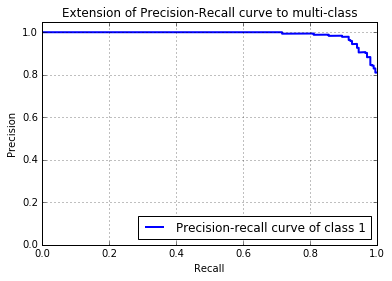

In [64]:
plt.clf()

plt.plot(recall[0], prcsn[0], linewidth = 2, label='Precision-recall curve of class 1')

# for i in range(2):
#     plt.plot(recall[i], prcsn[i], linewidth = 6 - 2*i,
#              label='Precision-recall curve of class {0} (area = {1:0.2f})'
#                    ''.format(i+1, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [66]:
df = pd.DataFrame(sss)
df.head()
X = df.ix[:, 0:2]
y = df.ix[:, 4]


In [67]:
model = pd.ols(x = X, y = y)
model


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <0> + <1> + <2> + <intercept>

Number of Observations:         249
Number of Degrees of Freedom:   4

R-squared:         0.9529
Adj R-squared:     0.9524

Rmse:              0.0120

F-stat (3, 245):  1653.4419, p-value:     0.0000

Degrees of Freedom: model 3, resid 245

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             0    -0.0794     0.0017     -45.58     0.0000    -0.0828    -0.0760
             1    -0.0082     0.0009      -8.68     0.0000    -0.0100    -0.0063
             2     0.0390     0.0029      13.25     0.0000     0.0332     0.0447
     intercept    -0.0013     0.0008      -1.66     0.0986    -0.0029     0.0002
---------------------------------End of Summary------------------

In [60]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [61]:
estimator = LinearRegression()
selector = RFE(estimator, 3, step=1)
selector = selector.fit(X, y)
selector.support_, selector.ranking_

(array([ True,  True,  True, False], dtype=bool), array([1, 1, 1, 2]))

In [18]:
a = np.array([[0], [1]])
a = np.append(a, [[2]], axis=0)

In [19]:
a

array([[0],
       [1],
       [2]])

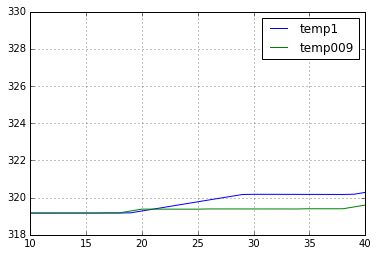

In [28]:
temp1 = pd.read_csv('temp1.csv')
temp009 = pd.read_csv('temp009.csv')
temp = pd.concat((temp1, temp009), axis=1)
temp.columns = ['temp1', 'temp009']
temp.plot(xlim=(10, 40), ylim=(318, 330), grid=True)

In [22]:
temp.ix[40:65, ]

,temp1,temp009
40,320.278122,319.596619
41,320.375945,319.596172
42,320.473670,319.595726
43,320.571298,319.595281
44,320.668827,319.606830
45,320.766260,319.606373
46,320.863595,319.605917
47,320.960833,319.605461
48,321.057973,319.605006
49,321.155017,319.604551


In [9]:
%run -p -s cumulative tests.py

Total number of tasks released:  750
Missed tasks:  {}
 